<a href="https://colab.research.google.com/github/Pari510/website/blob/main/Sentiment-Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment-Analyse

In [1]:
!pip install transformers[torch]
!pip install wordcloud
!pip install transformers gradio
!pip install python-docx
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

## Umgebungseinstellung

In [2]:
# Google Colab spezifische Importe
from google.colab import files
from google.colab import drive

# Datenverarbeitung und Modelltraining
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Transformer Modelle und Tokenizer
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification,
    GPT2Tokenizer, GPT2ForSequenceClassification,
    BartTokenizer, BartForSequenceClassification,
    T5Tokenizer, T5ForConditionalGeneration
)

# PyTorch Bibliotheken
import torch
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

# Weitere Bibliotheken
from tqdm import tqdm
import gradio as gr
import docx
from collections import Counter
import re
from wordcloud import WordCloud

## Daten hochladen und laden

In [3]:
# Funktion zum Hochladen von Dateien in Google Colab
def upload_files():
    uploaded = files.upload()
    return uploaded

# CSV-Datei laden
uploaded = upload_files()
train_data = pd.read_csv('Sentiment_Training.csv', delimiter=';')
test_data = pd.read_csv('Sentiment_Test.csv', delimiter=';')

Saving Sentiment_Test.csv to Sentiment_Test.csv
Saving Sentiment_Training.csv to Sentiment_Training.csv


## Explorative Datenanalyse

Erste Zeilen des Trainingsdatensatzes:
   label                                               text
0      4  I stalk this truck.  I've been to industrial p...
1      2  who really knows if this is good pho or not, i...
2      4  I LOVE Bloom Salon... all of their stylist are...
3      0  We were excited to eat here, it is difficult t...
4      2  So this is a place, with food. That much canno...

Informationen zum Trainingsdatensatz:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10000 non-null  int64 
 1   text    10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB
None

Statistik der Textlängen im Trainingsdatensatz:
count    10000.000000
mean       729.239800
std        653.262897
min          2.000000
25%        283.000000
50%        544.000000
75%        968.000000
max       5015.000000
Name: text_length, dtype: flo

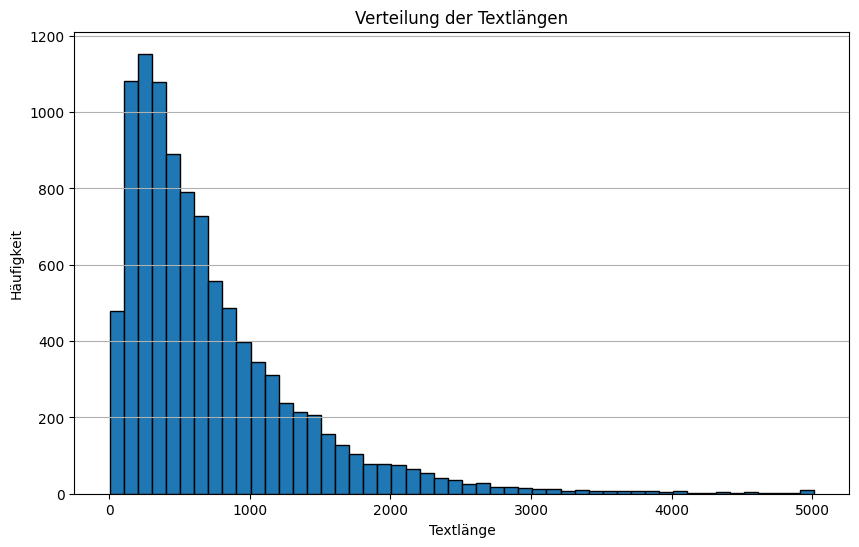


Verteilung der Labels im Trainingsdatensatz:
label
0    2035
1    1977
2    1943
3    1991
4    2054
Name: count, dtype: int64


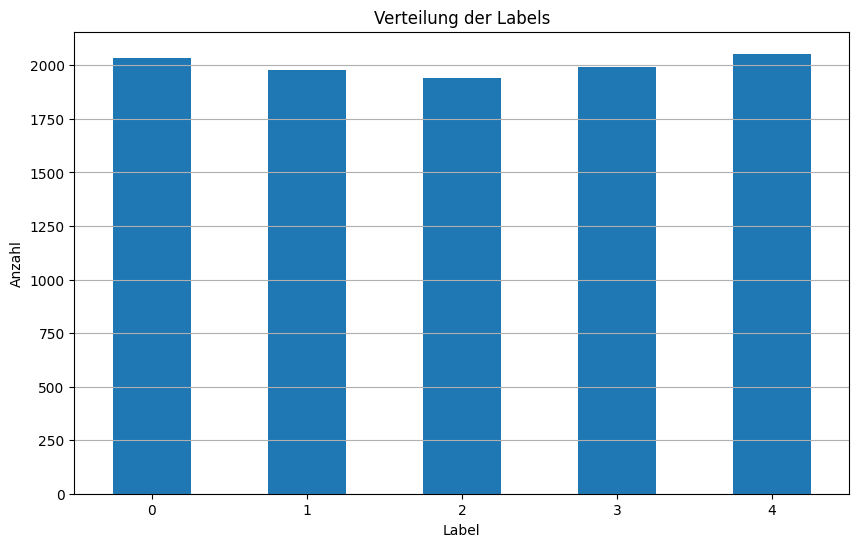

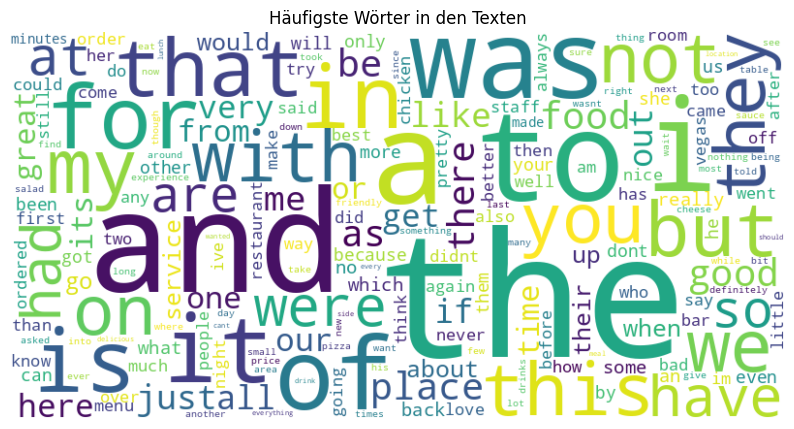

<Figure size 1000x600 with 0 Axes>

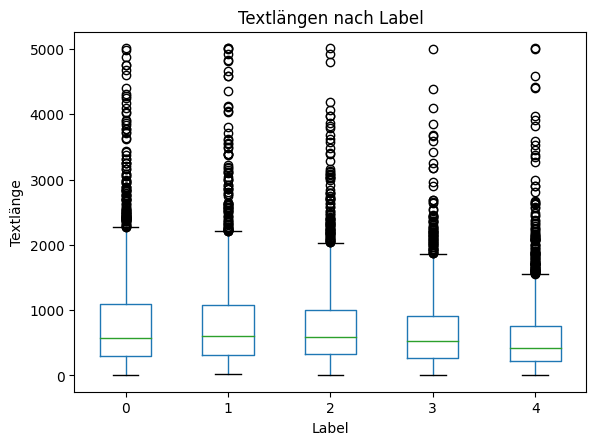


Textlängen nach Label:
        count        mean         std   min     25%    50%      75%     max
label                                                                      
0      2035.0  815.115971  747.139814   2.0  302.50  579.0  1091.00  5015.0
1      1977.0  809.385432  704.992632  21.0  320.00  602.0  1075.00  5014.0
2      1943.0  763.033968  642.396337   7.0  322.50  597.0  1008.50  5011.0
3      1991.0  675.672526  560.609923  10.0  273.00  534.0   913.00  5003.0
4      2054.0  586.973223  560.745037   8.0  217.25  417.5   752.75  5009.0


In [4]:
# Anzeigen der ersten Zeilen und Informationen
print("Erste Zeilen des Trainingsdatensatzes:")
print(train_data.head())

print("\nInformationen zum Trainingsdatensatz:")
print(train_data.info())

# Textlänge berechnen
train_data['text_length'] = train_data['text'].apply(len)
print("\nStatistik der Textlängen im Trainingsdatensatz:")
print(train_data['text_length'].describe())

# Histogramm der Textlängen
plt.figure(figsize=(10, 6))
plt.hist(train_data['text_length'], bins=50, edgecolor='black')
plt.title('Verteilung der Textlängen')
plt.xlabel('Textlänge')
plt.ylabel('Häufigkeit')
plt.grid(axis='y')
plt.show()

# Verteilung der Labels
print("\nVerteilung der Labels im Trainingsdatensatz:")
print(train_data['label'].value_counts().sort_index())

# Plot der Verteilung der Labels
label_distribution = train_data['label'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
label_distribution.plot(kind='bar')
plt.title('Verteilung der Labels')
plt.xlabel('Label')
plt.ylabel('Anzahl')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# Funktion zur Bereinigung und Tokenisierung von Text
def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    return tokens

# Alle Wörter tokenisieren
all_words = train_data['text'].apply(tokenize).sum()

# Häufigste Wörter ermitteln
word_counts = Counter(all_words)
common_words = word_counts.most_common(20)

# WordCloud generieren
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Plot der WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Häufigste Wörter in den Texten')
plt.show()

# Textlängen nach Label gruppieren und beschreiben
text_length_by_label = train_data.groupby('label')['text_length'].describe()

# Boxplot der Textlängen nach Label
plt.figure(figsize=(10, 6))
train_data.boxplot(column='text_length', by='label', grid=False)
plt.title('Textlängen nach Label')
plt.suptitle('')
plt.xlabel('Label')
plt.ylabel('Textlänge')
plt.show()

# Ausgabe der Textlängen nach Label
print("\nTextlängen nach Label:")
print(text_length_by_label)

## Slang-Wörterbuch laden

In [5]:
# Funktion zum Lesen der Word-Datei und erstellen eines Slang-Wörterbuchs
def read_slang_dict_from_docx(docx_file):
    doc = docx.Document(docx_file)
    slang_dict = {}
    for para in doc.paragraphs:
        if ':' in para.text:
            key, value = para.text.split(':', 1)
            slang_dict[key.strip().lower()] = value.strip().lower()
    return slang_dict

# Word-Datei hochladen und lesen
uploaded = upload_files()
docx_file = next(iter(uploaded))
slang_dict = read_slang_dict_from_docx(docx_file)
print("Slang Dictionary:", slang_dict)

Saving abbreviations.docx to abbreviations.docx
Slang Dictionary: {'u': 'you', 'ur': 'your', 'r': 'are', 'idk': 'i don’t know', 'btw': 'by the way', 'omg': 'oh my god', 'lol': 'laugh out loud', 'brb': 'be right back', 'gtg': 'got to go', 'smh': 'shaking my head', 'tbh': 'to be honest', 'wth': 'what the heck', 'rofl': 'rolling on the floor laughing', 'stfu': 'shut the fuck up', 'icymi': 'in case you missed it', 'tl;dr': 'too long, didn’t read', 'tmi': 'too much information', 'afaik': 'as far as i know', 'lmk': 'let me know', 'nvm': 'nevermind', 'ftw': 'for the win', 'byob': 'bring your own beer', 'bogo': 'buy one get one', 'jk': 'just kidding', 'jw': 'just wondering', 'tgif': 'thank goodness it’s friday', 'tbf': 'to be frank', 'rn': 'right now', 'fubar': 'fucking up beyond all recognition', 'iso': 'in search of', 'brt': 'be right there', 'ftfy': 'fixed that for you', 'gg': 'good game', 'bfd': 'big freaking deal', 'irl': 'in real life', 'dae': 'does anyone else?', 'ngl': 'not gonna lie',

In [6]:
def find_slang_words(df, slang_dict):
    slang_words_found = []

    for text in df['text']:
        words = text.split()
        for word in words:
            if word.lower() in slang_dict:
                slang_words_found.append(word.lower())

    return Counter(slang_words_found)

# Finden von Slang-Wörtern im Trainingsdatensatz
slang_words_counter = find_slang_words(train_data, slang_dict)

# Anzeige der Slang-Wörter und ihrer Häufigkeit
print(slang_words_counter)

Counter({'u': 116, 'im': 94, 'bf': 72, 'pm': 63, 'lol': 41, 'bc': 33, 'gf': 32, 'r': 22, 'til': 17, 'ur': 16, 'fyi': 15, 'omg': 15, 'aka': 12, 'wtf': 10, 'btw': 8, 'abt': 7, 'x': 7, 'wth': 6, 'diy': 6, 'cob': 5, 'imo': 5, 'tgif': 4, 'smh': 3, 'idk': 3, 'asap': 3, 'byob': 3, 'bogo': 3, 'imho': 3, 'jk': 2, 'wa': 2, 'tlc': 2, 'fb': 2, 'pov': 1, 'sc': 1, 'n/a': 1, 'bfd': 1, 'pda': 1, 'tia': 1, 'mms': 1, 'ff': 1, 'tt': 1, 'stfu': 1, 'lmao': 1, 'np': 1, 'sms': 1, 'tmi': 1, 'w/e': 1})


## Textvorverarbeitung

In [7]:
def preprocess_text(text, slang_dict):
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    new_words = [slang_dict.get(word.lower(), word) for word in words]
    text = ' '.join(new_words)
    return text

In [8]:
# Anwenden der Preprocessing-Funktion auf den Trainingsdatensatz
train_data['processed_text'] = train_data['text'].apply(lambda x: preprocess_text(x, slang_dict))

# Anwenden der Preprocessing-Funktion auf den Testdatensatz
test_data['processed_text'] = test_data['text'].apply(lambda x: preprocess_text(x, slang_dict))

In [9]:
# Anzeigen der ersten Zeilen des verarbeiteten Trainingsdatensatzes
print("Erste Zeilen des verarbeiteten Trainingsdatensatzes:")
print(train_data[['text', 'processed_text']].head())

Erste Zeilen des verarbeiteten Trainingsdatensatzes:
                                                text  \
0  I stalk this truck.  I've been to industrial p...   
1  who really knows if this is good pho or not, i...   
2  I LOVE Bloom Salon... all of their stylist are...   
3  We were excited to eat here, it is difficult t...   
4  So this is a place, with food. That much canno...   

                                      processed_text  
0  I stalk this truck. I've been to industrial pa...  
1  who really knows if this is good pho or not, i...  
2  I LOVE Bloom Salon... all of their stylist are...  
3  We were excited to eat here, it is difficult t...  
4  So this is a place, with food. That much canno...  


## Datenvorbereitung

In [10]:
# Funktion zur Kategorisierung der Sternebewertungen
def categorize_rating(rating):
    if rating <= 1:
        return 'negative'
    elif rating == 2:
        return 'neutral'
    else:
        return 'positive'

# Anwenden der Funktion auf die Trainings- und Testdaten
train_data['sentiment'] = train_data['label'].apply(categorize_rating)
test_data['sentiment'] = test_data['label'].apply(categorize_rating)


Verteilung der Kategorien im Trainingsdatensatz:
sentiment
negative    4012
neutral     1943
positive    4045
Name: count, dtype: int64


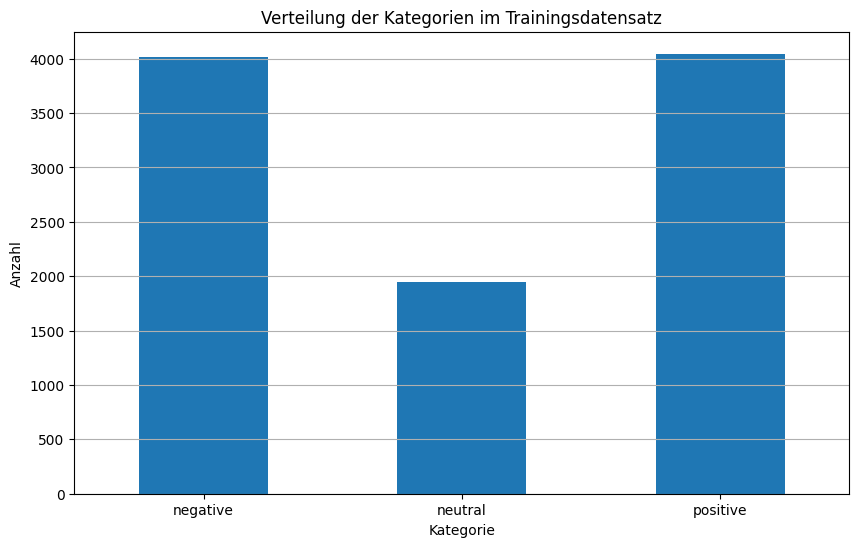

In [11]:
# Verteilung der Kategorien im Trainingsdatensatz
print("\nVerteilung der Kategorien im Trainingsdatensatz:")
print(train_data['sentiment'].value_counts().sort_index())

# Plot der Verteilung der Kategorien
category_distribution = train_data['sentiment'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
category_distribution.plot(kind='bar')
plt.title('Verteilung der Kategorien im Trainingsdatensatz')
plt.xlabel('Kategorie')
plt.ylabel('Anzahl')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [12]:
# Trainingsdaten in Trainings- und Validierungsdatensätze aufteilen
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['sentiment'], random_state=42)

In [13]:
# Ausgabe der Textlängen nach Label
text_length_by_label = train_data.groupby('label')['text_length'].describe()
print("\nTextlängen nach Label:")
print(text_length_by_label)


Textlängen nach Label:
        count        mean         std   min     25%    50%     75%     max
label                                                                     
0      1615.0  827.540557  763.488666   2.0  315.00  583.0  1087.0  5015.0
1      1595.0  812.539812  704.085216  26.0  323.50  600.0  1085.5  5014.0
2      1554.0  765.365508  635.490730   7.0  328.25  596.0  1000.0  4930.0
3      1609.0  663.192045  547.375703  10.0  269.00  520.0   898.0  5003.0
4      1627.0  585.634911  570.775732  11.0  212.50  419.0   752.0  5009.0


## Dataset und Tokenisierung

In [14]:
# Dataset-Klasse definieren
class YelpDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.clone().detach().requires_grad_(False)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Funktion zum Tokenisieren der Daten
def tokenize_data(data, tokenizer, slang_dict, model_name=None, max_length=128):
    # Preprocessing der Texte
    texts = [preprocess_text(text, slang_dict) for text in data['text'].tolist()]
    labels = pd.Categorical(data['sentiment']).codes

    if model_name == 'T5':
        inputs = tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
        targets = ["positive" if label == 2 else "neutral" if label == 1 else "negative" for label in labels]
        target_inputs = tokenizer(targets, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
        return inputs, target_inputs.input_ids
    else:
        inputs = tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
        return inputs, torch.tensor(labels)

## Modelle definieren

In [21]:
# Tokenizer und Modelle definieren
model_configs = {
    'BERT': {
        'tokenizer': BertTokenizer.from_pretrained('bert-base-uncased'),
        'model': BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    },
    'RoBERTa': {
        'tokenizer': RobertaTokenizer.from_pretrained('roberta-base'),
        'model': RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
    },
    'DistilBERT': {
        'tokenizer': DistilBertTokenizer.from_pretrained('distilbert-base-uncased'),
        'model': DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
    },
    'GPT-2': {
        'tokenizer': GPT2Tokenizer.from_pretrained('gpt2'),
        'model': GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=3)
    },
    'BART': {
        'tokenizer': BartTokenizer.from_pretrained('facebook/bart-base'),
        'model': BartForSequenceClassification.from_pretrained('facebook/bart-base', num_labels=3)
    },
    'T5': {
        'tokenizer': T5Tokenizer.from_pretrained('t5-base'),
        'model': T5ForConditionalGeneration.from_pretrained('t5-base')
    }
}

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Training und Evaluierung

In [22]:
# Alle Tokenizer haben ein pad_token und passen zum jeweiligen Modell
for model_name, config in model_configs.items():
    tokenizer = config['tokenizer']
    model = config['model']

    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
        model.resize_token_embeddings(len(tokenizer))

    # Erforderliche pad_token_id für Modelle setzen
    model.config.pad_token_id = tokenizer.pad_token_id
    assert tokenizer.pad_token is not None, f"Pad token nicht hinzugefügt für {model_name}"

# Optimizer definieren
def get_optimizer(model):
    return optim.AdamW(model.parameters(), lr=5e-5)

# Trainingsschleife mit Gewichtung
def train(model, train_loader, optimizer, device, class_weights, model_name=None):
    model.train()
    total_loss = 0
    class_weights = class_weights.to(device)
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).long()

        if model_name == 'T5':
            decoder_input_ids = model._shift_right(labels)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=decoder_input_ids, labels=labels)
            loss = outputs.loss
        else:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = torch.nn.functional.cross_entropy(logits, labels, weight=class_weights)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

# Evaluierungsschleife
def evaluate(model, val_loader, device, tokenizer, model_name=None):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).long()

            if model_name == 'T5':
                decoder_input_ids = model._shift_right(labels)
                outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128)
                preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
                true_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

                outputs_loss = model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=decoder_input_ids, labels=labels)
                loss = outputs_loss.loss
                total_loss += loss.item()

                correct_predictions += sum([1 if pred.strip() == true_label.strip() else 0 for pred, true_label in zip(preds, true_labels)])
                pred_labels = [2 if pred.strip() == "positive" else 1 if pred.strip() == "neutral" else 0 for pred in preds]
                true_label_ids = [2 if true_label.strip() == "positive" else 1 if true_label.strip() == "neutral" else 0 for true_label in true_labels]
                all_preds.extend(pred_labels)
                all_labels.extend(true_label_ids)
            else:
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                loss = torch.nn.functional.cross_entropy(logits, labels)
                total_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                correct_predictions += torch.sum(preds == labels).item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

    accuracy = correct_predictions / len(val_loader.dataset)
    return total_loss / len(val_loader), accuracy, all_labels, all_preds

## Modelle trainieren und speichern

Training BART - Epoch 1/1


100%|██████████| 125/125 [00:08<00:00, 15.34it/s]


Train Loss: 0.7604, Val Loss: 0.6540, Val Accuracy: 0.7030

Confusion Matrix for BART:
[[501 283  18]
 [ 28 312  49]
 [ 10 206 593]]

Classification Report for BART:
              precision    recall  f1-score   support

    negative       0.93      0.62      0.75       802
     neutral       0.39      0.80      0.52       389
    positive       0.90      0.73      0.81       809

    accuracy                           0.70      2000
   macro avg       0.74      0.72      0.69      2000
weighted avg       0.81      0.70      0.73      2000



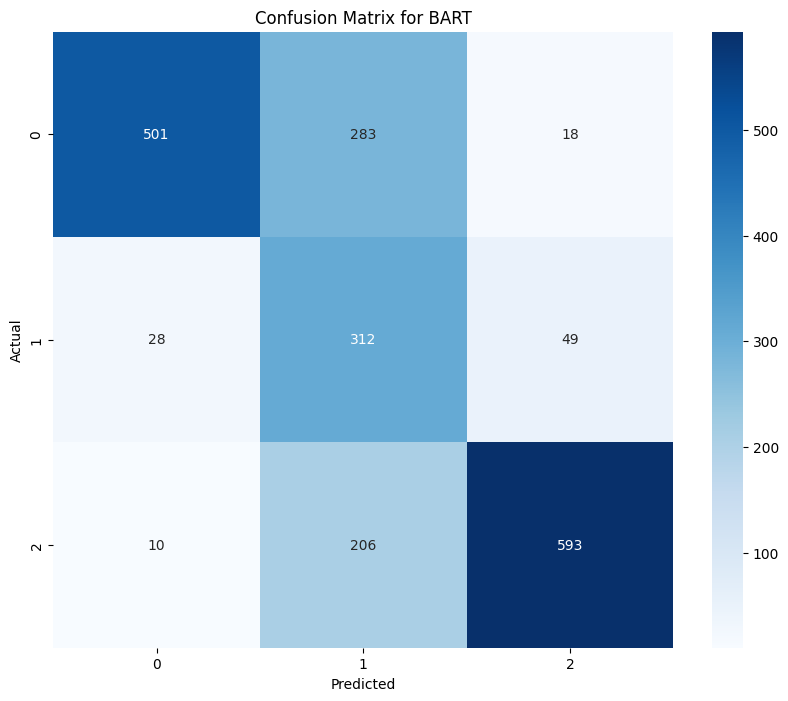

Training T5 - Epoch 1/1


100%|██████████| 125/125 [03:22<00:00,  1.62s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.6127, Val Loss: 0.0118, Val Accuracy: 0.6715

Confusion Matrix for T5:
[[778   0  24]
 [285   0 104]
 [211   0 598]]

Classification Report for T5:
              precision    recall  f1-score   support

    negative       0.61      0.97      0.75       802
     neutral       0.00      0.00      0.00       389
    positive       0.82      0.74      0.78       809

    accuracy                           0.69      2000
   macro avg       0.48      0.57      0.51      2000
weighted avg       0.58      0.69      0.62      2000



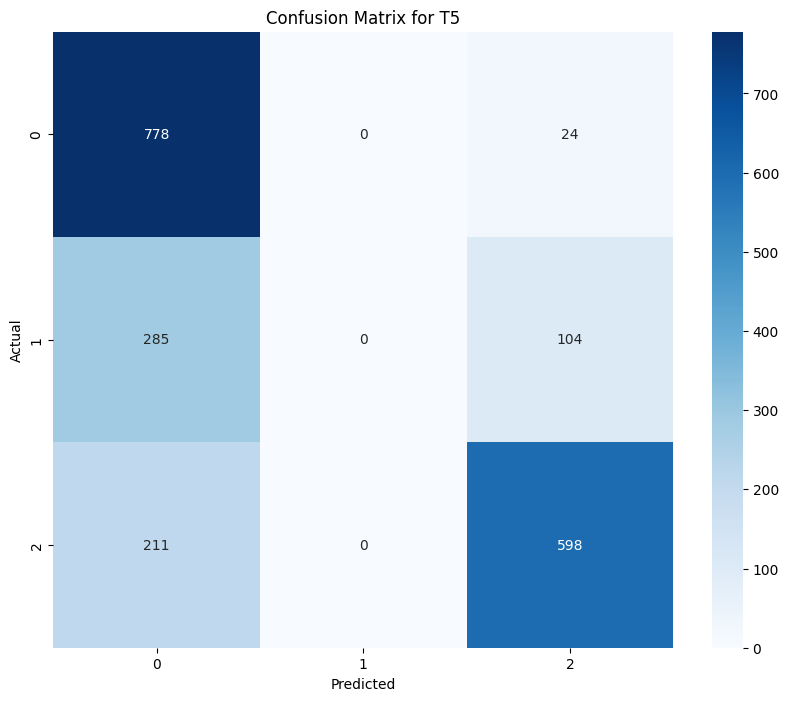

In [23]:
# Klassen-Gewichtungen
class_weights = torch.tensor([1.0, 2.0, 1.0])

trained_models = {}
for model_name, config in model_configs.items():
    tokenizer = config['tokenizer']
    model = config['model']

    # Tokenisieren der Trainings-, Validierungs- und Testdaten
    train_inputs, train_labels = tokenize_data(train_data, tokenizer, slang_dict, model_name)
    val_inputs, val_labels = tokenize_data(val_data, tokenizer, slang_dict, model_name)
    test_inputs, test_labels = tokenize_data(test_data, tokenizer, slang_dict, model_name)

    # Daten in Dataset-Objekte umwandeln
    train_dataset = YelpDataset(train_inputs, train_labels)
    val_dataset = YelpDataset(val_inputs, val_labels)
    test_dataset = YelpDataset(test_inputs, test_labels)

    # DataLoader erstellen
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # Modell auf GPU/CPU laden
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Optimizer definieren
    optimizer = get_optimizer(model)

    # Training und Evaluierung
    epochs = 1  # Anzahl der Epochen auf 3 erhöhen für den finalen Lauf
    for epoch in range(epochs):
        print(f"Training {model_name} - Epoch {epoch + 1}/{epochs}")
        train_loss = train(model, train_loader, optimizer, device, class_weights, model_name)
        val_loss, val_accuracy, val_labels, val_preds = evaluate(model, val_loader, device, tokenizer, model_name)
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Berechnung der Evaluationsmetriken
    conf_matrix = confusion_matrix(val_labels, val_preds)
    class_report = classification_report(val_labels, val_preds, target_names=['negative', 'neutral', 'positive'])

    print(f"\nConfusion Matrix for {model_name}:")
    print(conf_matrix)

    print(f"\nClassification Report for {model_name}:")
    print(class_report)

    # Confusion Matrix plotten
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Modell speichern
    trained_models[model_name] = {
        'model': model,
        'tokenizer': tokenizer,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'conf_matrix': conf_matrix,
        'class_report': class_report
    }

## Gradio-Oberfläche erstellen

In [24]:
# Gradio-Oberfläche erstellen
def classify_text(text):
    results = {}
    for model_name, model_info in trained_models.items():
        model = model_info['model']
        tokenizer = model_info['tokenizer']

        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
        if model_name == 'T5':
            outputs = model.generate(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=128)
            prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        else:
            outputs = model(**inputs)
            prediction = torch.argmax(outputs.logits, dim=1).item()
            sentiments = {0: 'negative', 1: 'neutral', 2: 'positive'}
            prediction = sentiments[prediction]

        results[model_name] = prediction

    return results

# Satz auswählen und Ergebnisse anzeigen
def get_test_sentence(index):
    try:
        index = int(index.split(":")[0])
        text = test_data.iloc[index]['text']
        original_label = test_data.iloc[index]['sentiment']
        return text, original_label
    except Exception as e:
        print(f"Error in get_test_sentence: {e}")
        return "", ""

def get_results_for_test_sentence(index):
    try:
        print(f"Selected index: {index}")
        text, original_label = get_test_sentence(index)
        if text == "":
            return {"error": "Invalid index or text not found"}, ""
        results = classify_text(text)
        results['Original Label'] = original_label
        return results, text
    except Exception as e:
        print(f"Error in get_results_for_test_sentence: {e}")
        return {"error": "An error occurred"}, ""

# Gradio-Komponente für den Satz-Picker
sentence_picker = gr.Dropdown(
    choices=[f"{i}: {text[:50]}" for i, text in enumerate(test_data['text'])],
    label="Wähle einen Satz aus dem Testdatensatz",
    interactive=True
)

# Gradio-Oberfläche erstellen
interface = gr.Interface(
    fn=get_results_for_test_sentence,
    inputs=sentence_picker,
    outputs=[gr.Json(label="Ergebnisse"), gr.Textbox(label="Selected Text")],
    title="Ergebnisse für einen Satz aus dem Testdatensatz"
)

# Starten der Gradio-Oberfläche
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://017de28718182082e2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
